# **Sea Nodes 생성 및 저장**

* sea_nodes는 해양 부분만 포함

* 경로 생성 시 육지 부분을 걸러내기 위함

In [ ]:
!pip install basemap
!pip install basemap-data-hires

!pip install ipympl
!pip install nodejs-bin
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib
!pip install graphviz
!pip install shapely
!pip install Fiona

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir] [--paths] [--json]
               [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: bundlerextension console dejavu execute kernel kernelspec migrate nbclassic
nbconvert nbextension notebook run server serverextension troubleshoot trust

Jupyter command `jupyter-labextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir] [--paths] [

In [ ]:
import shapely.geometry
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from datetime import datetime
import time
import copy

import math
import IPython
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install import_ipynb
import import_ipynb

%cd '/content/drive/MyDrive/Colab Notebooks/PathRecommendation/'
import gridify

/content/drive/MyDrive/Colab Notebooks/PathRecommendation


### 1. 베이스맵 위 노드 그래프 생성

In [ ]:
import shapely.geometry
import pandas as pd
import numpy as np
import importlib

grid = gridify.area_to_grid(side_length=3000)

Original NE: POINT (127.5 35)
Original SW: POINT (125.5 33)
Transformed NE: (245644.2847211206, 167209.11817988113)
Transformed SW: (59813.61210262391, -53750.405247235205)
col_count 61
row_count 73
grid_size 4453


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<string>:161: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
<string>:162: FutureWarning: This function is deprecated. See: https://pyp

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap

def visualize_graph(graph, grid):
    nodes = graph.original.drop_duplicates().values
    lats = []
    lons = []
    for node in nodes:
        latlon = grid.extract_coords_lat_lon(node)
        lats.append(latlon[0])
        lons.append(latlon[1])

    nodes = graph.connected.drop_duplicates().values
    lats2 = []
    lons2 = []
    for node in nodes:
        latlon = grid.extract_coords_lat_lon(node)
        lats2.append(latlon[0])
        lons2.append(latlon[1])

    f = plt.figure(figsize=[25,25])
    m = Basemap(llcrnrlon = min(lons),llcrnrlat = min(lats), urcrnrlon = max(lons),
               urcrnrlat = max(lats),
               resolution='l')
    m.shadedrelief()

    plt.plot(lons2, lats2, 'o', c='red', alpha=1, markersize=4)
    plt.plot(lons, lats, 'o', c='orange', alpha=1, markersize=4)

    plt.show()

def visualize_graph_connections(graph, grid):
    rows = graph.drop_duplicates().values
    lats = []
    lons = []

    m = Basemap(llcrnrlon = min(lons),llcrnrlat = min(lats), urcrnrlon = max(lons),
               urcrnrlat = max(lats),
               resolution='l')
    m.shadedrelief()

    f = plt.figure(figsize=[25,25])
    for row in rows:
        original_latlon = grid.extract_coords_lat_lon(row[0])
        connected_latlon = grid.extract_coords_lat_lon(row[1])
        lats = [original_latlon[0], connected_latlon[0]]
        lons = [original_latlon[1], connected_latlon[1]]

        plt.plot(lons, lats, alpha=1, markersize=2, linewidth=1, c='black')


    plt.show()

In [ ]:
import pandas as pd

%time sea_graph = gridify.create_area_graph(grid, adjacent=True)
graph_cols = ['original', 'connected']
sea_graph = pd.DataFrame(sea_graph, columns=graph_cols)

sea_graph.head(5)

CPU times: user 61.4 ms, sys: 0 ns, total: 61.4 ms
Wall time: 146 ms


,original,connected
0,0,1
1,0,73
2,0,74
3,1,0
4,1,2


<string>:90: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


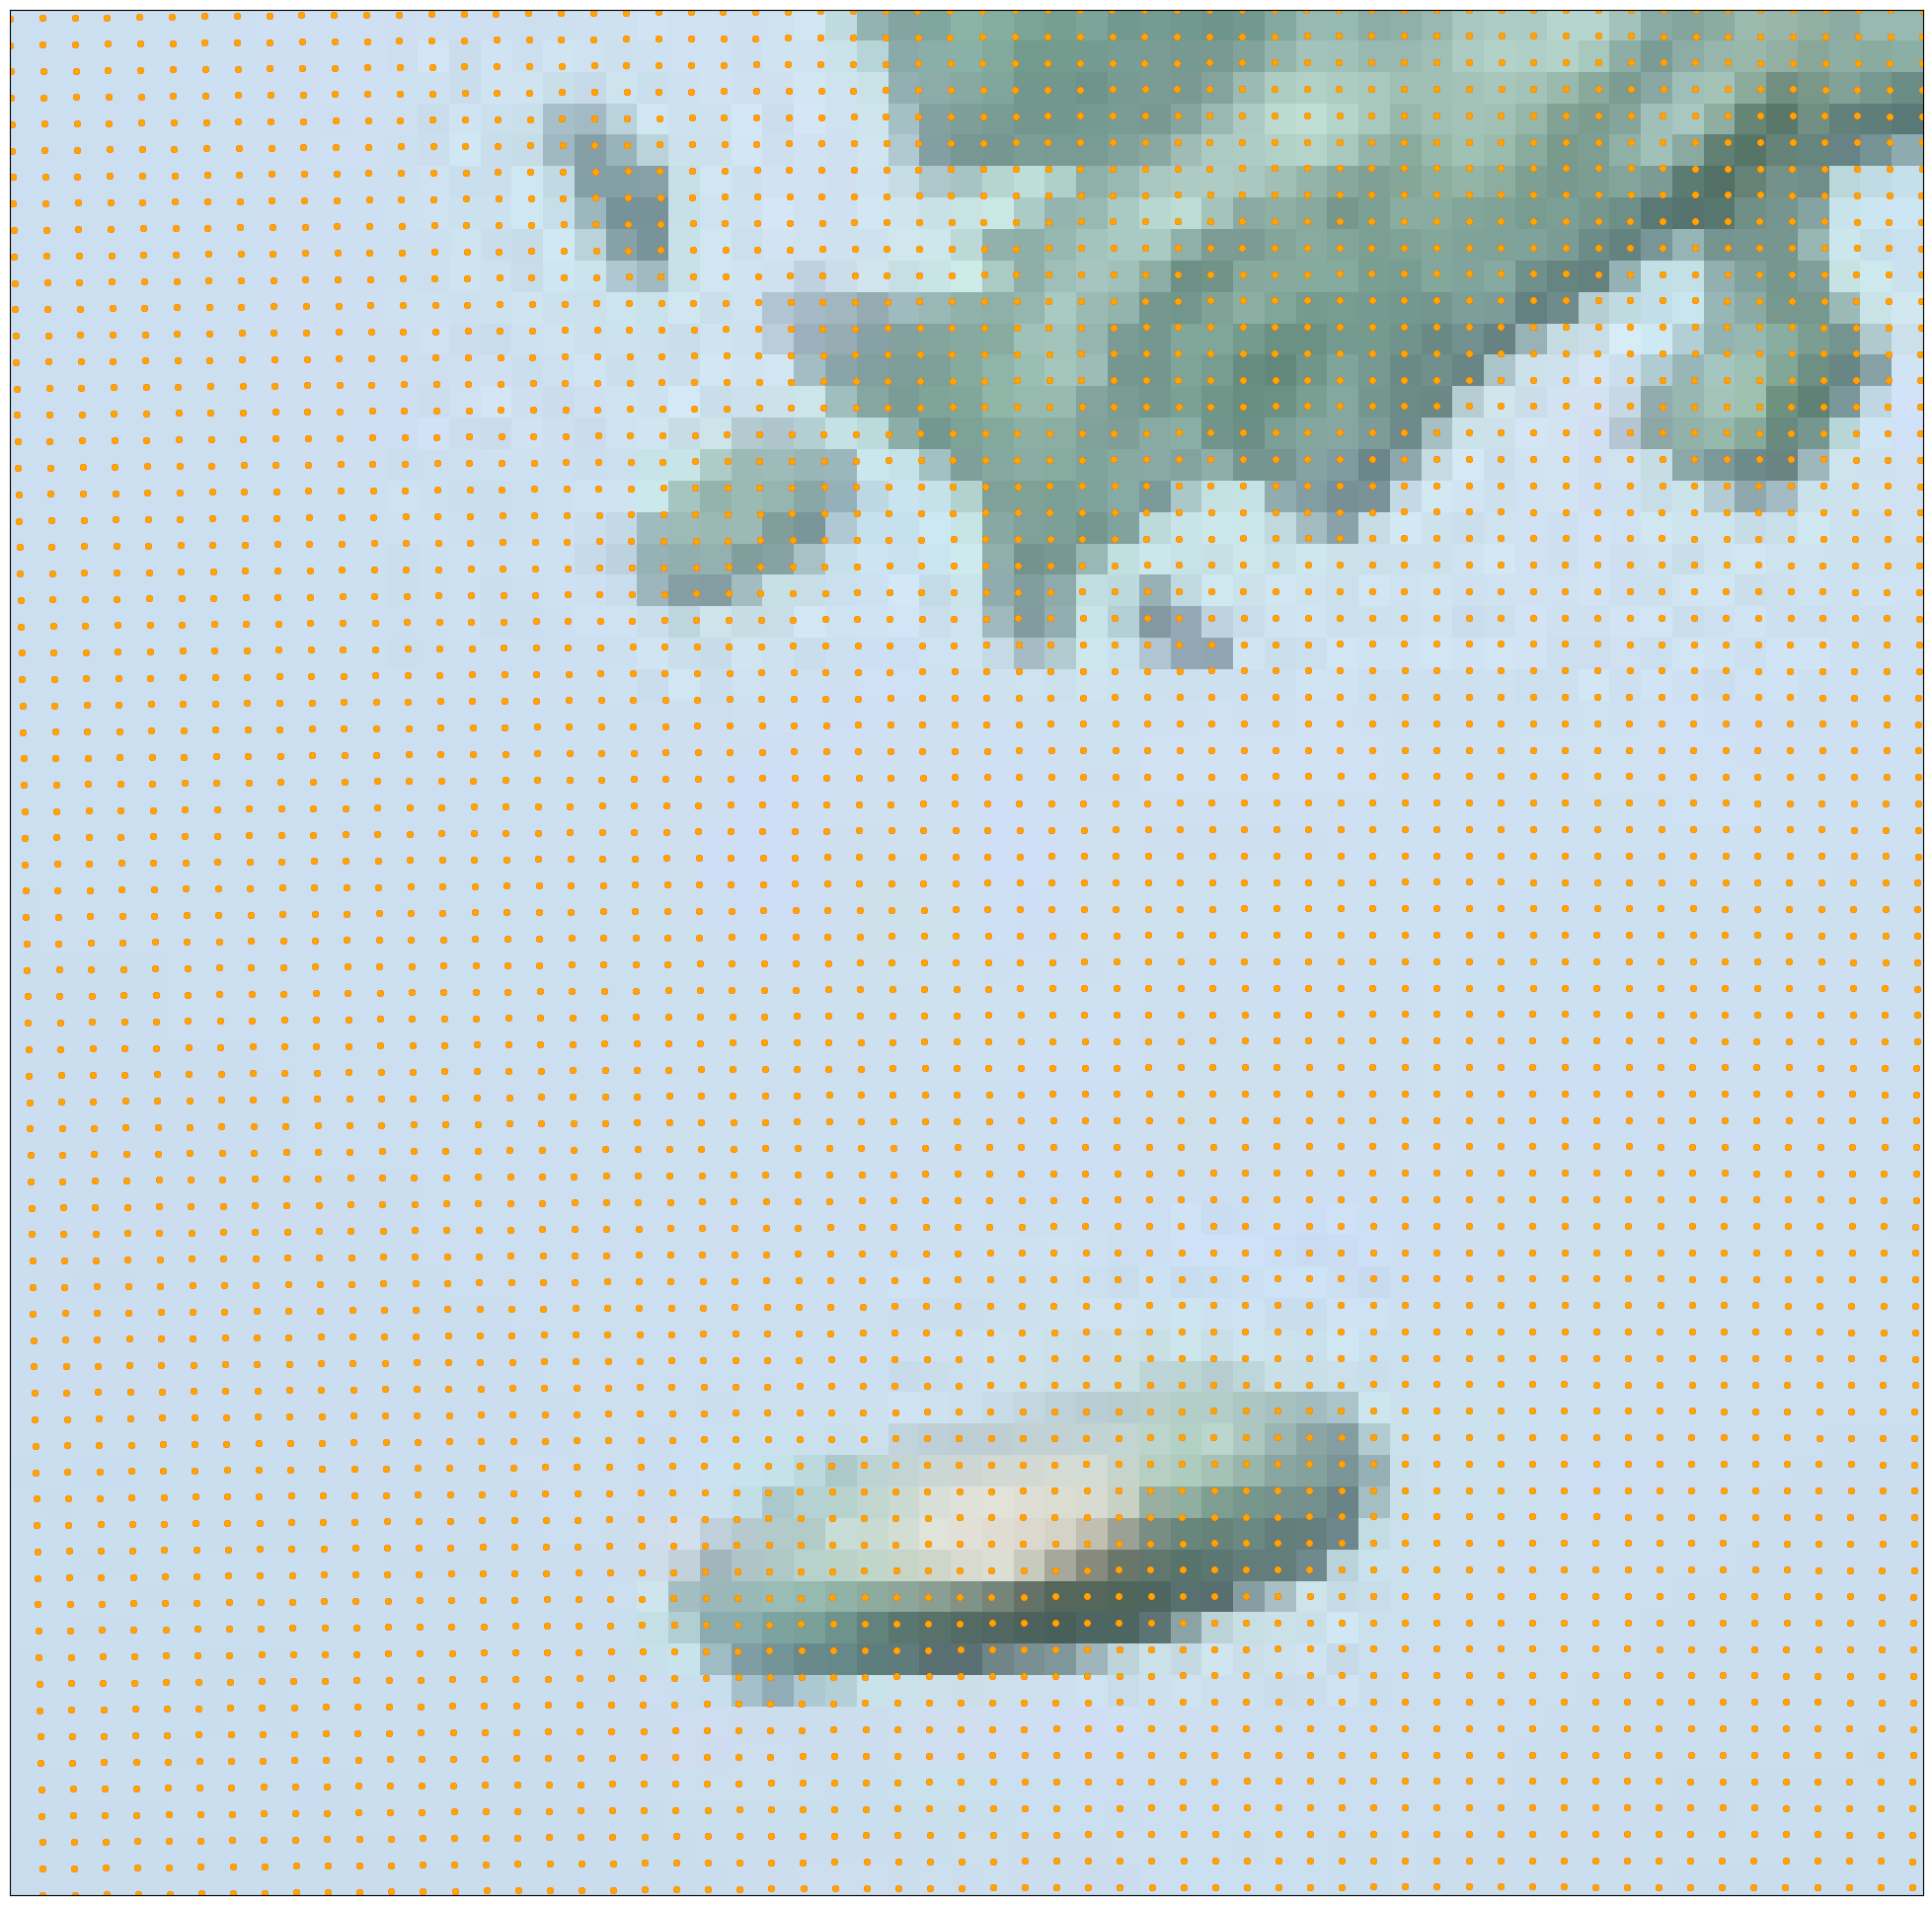

In [ ]:
visualize_graph(sea_graph, grid)

### 2. shp파일 이용하여 육지 노드 제거 및 저장

In [ ]:
import fiona
import pyproj
from shapely.geometry import shape
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from shapely.geometry import Point

def get_nodes_inside_area(graph, area):
    keep = []
    for node in graph.original.drop_duplicates().values:
        latlon = grid.extract_coords_lat_lon(node)
        p = Point((latlon[1], latlon[0]))
        if area.contains(p):
            keep.append(node)
    return set(keep)

from tqdm import tqdm

def get_nodes_not_inside_area_accurate(graph, area):
    keep = []
    for node in tqdm(graph.original.drop_duplicates().values):
        rowcol = grid.extract_coords(node)
        row = rowcol[0]
        col = rowcol[1]
        sw = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col], grid.rows[row]))
        se = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col] + grid.side_length, grid.rows[row]))
        nw = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col], grid.rows[row] + grid.side_length))
        ne = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col] + grid.side_length, grid.rows[row] + grid.side_length))
        pointlist = list([sw, se, ne, nw])

        cell = shapely.geometry.Polygon([[p.x, p.y] for p in pointlist])

        if  area.contains(cell):
            continue

        keep.append(node)

    return set(keep)

False
CPU times: user 569 µs, sys: 977 µs, total: 1.55 ms
Wall time: 1.55 ms
False
CPU times: user 559 µs, sys: 0 ns, total: 559 µs
Wall time: 563 µs


  0%|          | 0/4320 [00:00<?, ?it/s]<ipython-input-21-f3aed0ad1dc2>:25: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  sw = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col], grid.rows[row]))
<ipython-input-21-f3aed0ad1dc2>:26: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  se = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col] + grid.side_length, grid.rows[row]))
<ipython-input-21-f3aed0ad1dc2>:27: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  nw = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col], grid.rows[row] + grid.side_length))
<ipython-input-21-f3aed0ad1dc2>:28: FutureWarning: This function is deprecated. See: htt

CPU times: user 9min 32s, sys: 22.8 s, total: 9min 55s
Wall time: 10min 1s


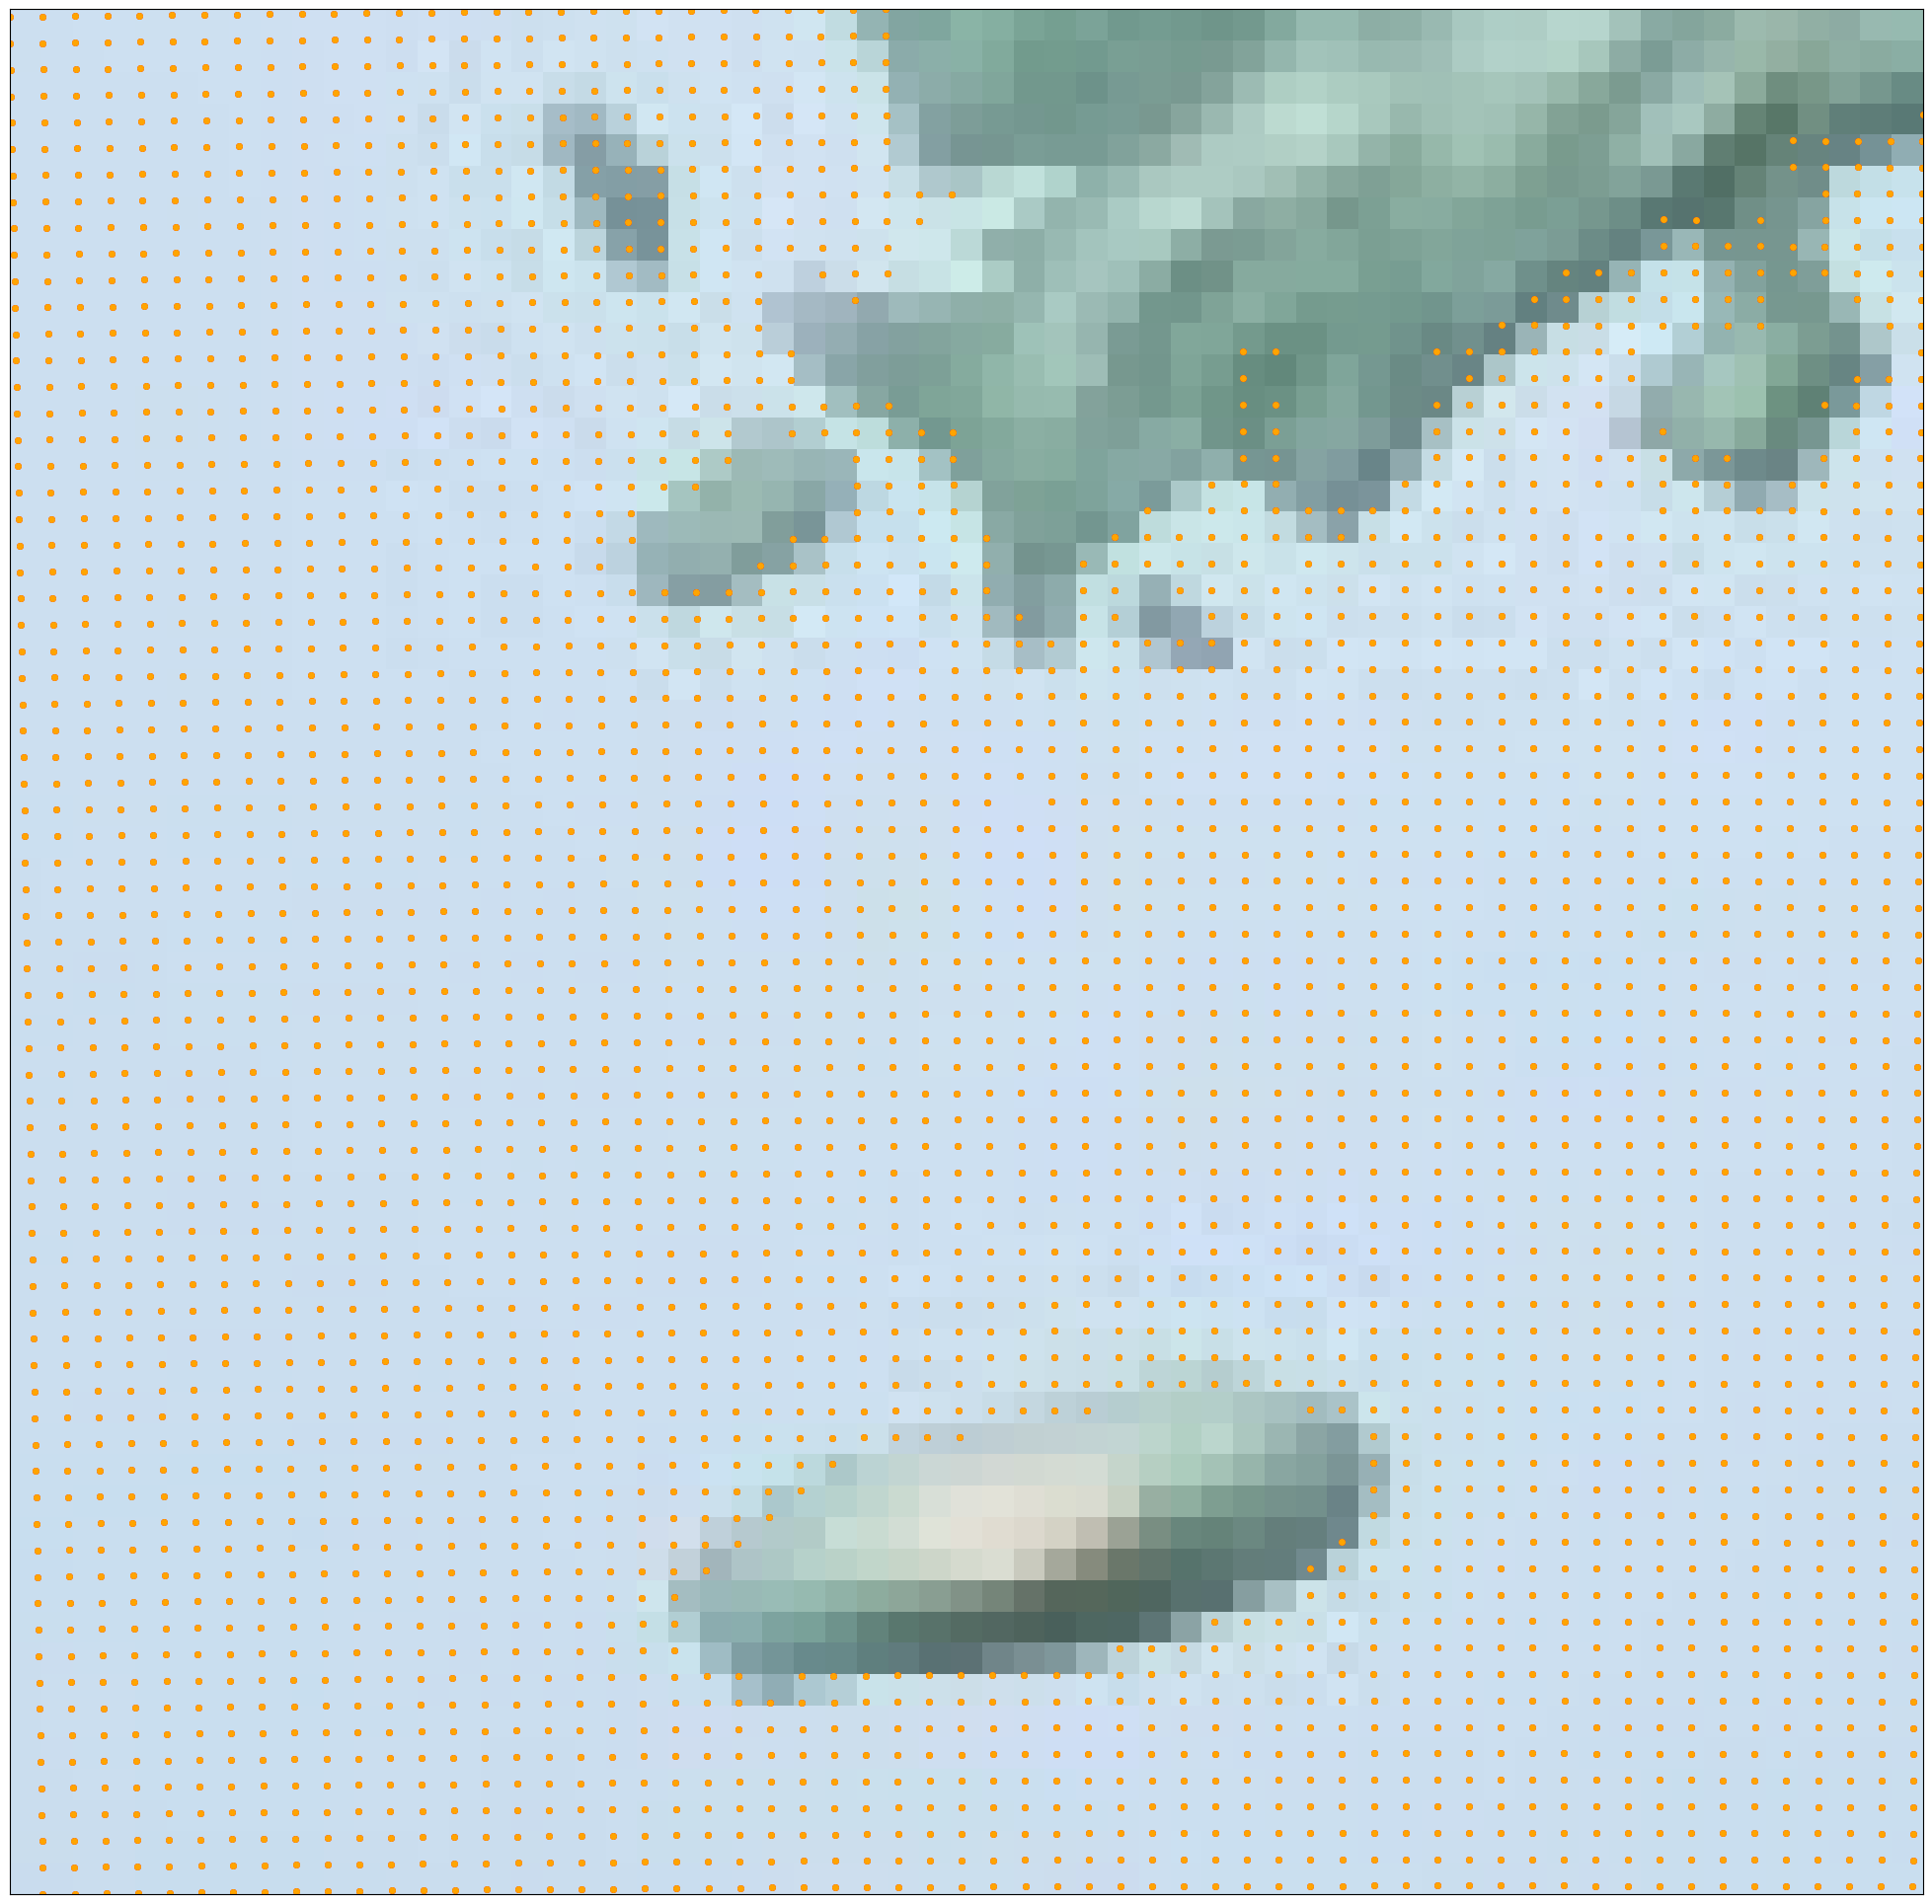

In [ ]:
land = MultiPolygon([shape(pol['geometry']) for pol in fiona.open('./data/shapes/4326_land.shp')])

%time print(land.contains(Point(30, 53)))
%time print(land.contains(Point(14.584798172002538,53.92132432670449)))

%time keep = get_nodes_not_inside_area_accurate(sea_graph, land)

sea_graph = sea_graph[sea_graph.original.isin(keep)]

originals = set(sea_graph.original.drop_duplicates().values)

sea_graph = sea_graph[sea_graph.connected.isin(originals)]

visualize_graph(sea_graph, grid)

In [ ]:
sea_nodes = set(sea_graph['original'].apply(lambda x: tuple(map(float, grid.extract_coords_lat_lon(x)))))

<string>:90: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


In [ ]:
#결과 저장
with open('./files/sea_nodes.pkl', 'wb') as f:
        pickle.dump(sea_nodes, f)